In [ ]:
# pip install simpletransformers

## Data loading

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
import torch
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.neighbors import NearestCentroid, KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn import metrics, tree
from sklearn.metrics import roc_auc_score, roc_curve, auc, recall_score, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.ensemble import GradientBoostingClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import logging

In [ ]:
df = pd.read_excel("/content/drive/MyDrive/Data/force1000-fake1000.xlsx")
df = shuffle(df)

In [ ]:
df[:4]

,Время,Сила,Δ новость и рывок,Новость,Разгон
1178,2020-03-30 10:02:00,0.054200,-59.216667,''Новости компаний — обзоры прессы перед откры...,0
1344,2019-11-05 10:50:00,0.099491,355.500000,​​ Банкиры не хотят принимать материнский капи...,0
399,2021-01-14 14:26:00,0.066056,20.516667,"🔥 🔥 🔥 Куйбышевазот ( KAZT , KAZTP) — драгоценн...",1
2003,2020-03-31 10:17:00,0.055294,-17.816667,"Транснефть #TRNFP Компании «Транснефть», «Сург...",0


## Data type conversion

In [ ]:
df["Сила"] = df["Сила"].round(4)
df["Δ новость и рывок"] = df["Δ новость и рывок"].round(1)
df["Время"] = df["Время"].astype("datetime64")
df["Сила"] = df["Сила"].astype("float64")
df["Δ новость и рывок"] = df["Δ новость и рывок"].astype("float64")
df["Новость"] = df["Новость"].astype("object")
df["Разгон"] = df["Разгон"].astype("bool")

## Excluding irrelevant columns

In [ ]:
X = df.drop(["Разгон", "Время",	"Сила",	"Δ новость и рывок"], axis = 1)
y = df.drop(["Время",	"Сила",	"Δ новость и рывок", "Новость"], axis = 1)

In [ ]:
train_df = df.drop(["Время",	"Сила",	"Δ новость и рывок"], axis = 1)[:round(0.7*len(df))]
eval_df = df.drop(["Время",	"Сила",	"Δ новость и рывок"], axis = 1)[round(0.7*len(df)):len(df)]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 77, test_size = 0.3, shuffle = True)

In [ ]:
X_train = df.Новость.values[:round(0.7*len(df))]
y_train = df.Разгон.values[:round(0.7*len(df))]
X_test = df.Новость.values[round(0.7*len(df)):len(df)]
y_test = df.Разгон.values[round(0.7*len(df)):len(df)]

## Simple Transformers

In [ ]:
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
# transformers_logger.setLevel(logging.WARNING)

In [ ]:
cuda_available = torch.cuda.is_available()
model_args = ClassificationArgs(num_train_epochs=5)
model = ClassificationModel("roberta", "roberta-base", use_cuda = cuda_available, args = {"learning_rate": 1e-4, "batch_size": 256, "overwrite_output_dir": True})

In [ ]:
model.train_model(train_df, verbose=False);
result, model_outputs, wrong_predictions = model.eval_model(eval_df, verbose=False);
result

## Rocchio (Nearest Centroid) classifier

In [ ]:
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', NearestCentroid())])

text_clf.fit(X_train, y_train)
predicted = text_clf.predict(X_test)
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

       False       0.83      0.87      0.85       304
        True       0.86      0.82      0.84       305

    accuracy                           0.85       609
   macro avg       0.85      0.85      0.85       609
weighted avg       0.85      0.85      0.85       609



In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, predicted).ravel()
fpr = fp / (fp + tn)
tpr = tp / (tp + fn)
rocchio_rocauc = round(roc_auc_score(y_test, predicted, average='weighted'), 2)

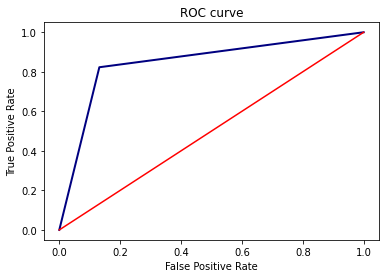

In [ ]:
plt.figure(figsize=(6, 4))
fpr, tpr, thresholds = roc_curve(y_test, predicted, pos_label=1)
plt.plot(fpr, tpr, lw=2, label='ROC curve ', color='navy')
plt.plot([0, 1], [0, 1], color = 'r')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

## Boosting

In [ ]:
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', GradientBoostingClassifier(n_estimators=100,
                      learning_rate=0.01, loss="exponential",
                      max_depth=None, random_state=14,
                      max_features="sqrt", n_iter_no_change=5,
                      validation_fraction=0.4, tol=0.01))])

text_clf.fit(X_train, y_train)
predicted = text_clf.predict(X_test)
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

       False       0.86      0.88      0.87       304
        True       0.88      0.86      0.87       305

    accuracy                           0.87       609
   macro avg       0.87      0.87      0.87       609
weighted avg       0.87      0.87      0.87       609



In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, predicted).ravel()
fpr = fp / (fp + tn)
tpr = tp / (tp + fn)
boosting_rocauc = round(roc_auc_score(y_test, predicted, average='weighted'), 2)

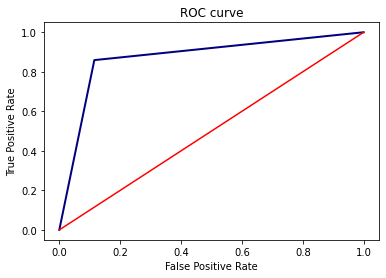

In [ ]:
plt.figure(figsize=(6, 4))
fpr, tpr, thresholds = roc_curve(y_test, predicted, pos_label=1)
plt.plot(fpr, tpr, lw=2, label='ROC curve ', color='navy')
plt.plot([0, 1], [0, 1], color = 'r')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

## Bagging

In [ ]:
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', BaggingClassifier(n_estimators=100,
                      oob_score=True, n_jobs=-1, random_state=57))])

text_clf.fit(X_train, y_train)
predicted = text_clf.predict(X_test)
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

       False       0.86      0.90      0.88       304
        True       0.89      0.86      0.88       305

    accuracy                           0.88       609
   macro avg       0.88      0.88      0.88       609
weighted avg       0.88      0.88      0.88       609



In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, predicted).ravel()
fpr = fp / (fp + tn)
tpr = tp / (tp + fn)
bagging_rocauc = round(roc_auc_score(y_test, predicted, average='weighted'), 2)

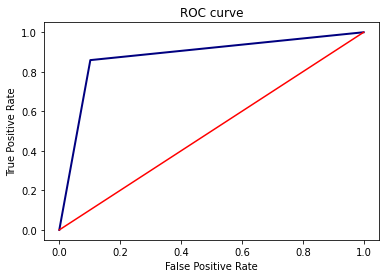

In [ ]:
plt.figure(figsize=(6, 4))
fpr, tpr, thresholds = roc_curve(y_test, predicted, pos_label=1)
plt.plot(fpr, tpr, lw=2, label='ROC curve ', color='navy')
plt.plot([0, 1], [0, 1], color = 'r')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

## Naive Bayes Classifier

In [ ]:
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB())])

text_clf.fit(X_train, y_train)
predicted = text_clf.predict(X_test)
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

       False       0.91      0.75      0.83       304
        True       0.79      0.93      0.85       305

    accuracy                           0.84       609
   macro avg       0.85      0.84      0.84       609
weighted avg       0.85      0.84      0.84       609



In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, predicted).ravel()
fpr = fp / (fp + tn)
tpr = tp / (tp + fn)
bayes_rocauc = round(roc_auc_score(y_test, predicted, average='weighted'), 2)

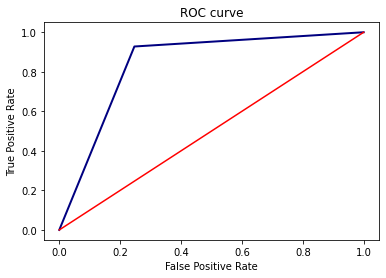

In [ ]:
plt.figure(figsize=(6, 4))
fpr, tpr, thresholds = roc_curve(y_test, predicted, pos_label=1)
plt.plot(fpr, tpr, lw=2, label='ROC curve ', color='navy')
plt.plot([0, 1], [0, 1], color = 'r')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

## K-nearest neighbors

In [ ]:
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', KNeighborsClassifier(n_jobs=-1))])

text_clf.fit(X_train, y_train)
predicted = text_clf.predict(X_test)
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

       False       0.87      0.80      0.84       304
        True       0.82      0.89      0.85       305

    accuracy                           0.84       609
   macro avg       0.85      0.84      0.84       609
weighted avg       0.85      0.84      0.84       609



In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, predicted).ravel()
fpr = fp / (fp + tn)
tpr = tp / (tp + fn)
neighbor_rocauc = round(roc_auc_score(y_test, predicted, average='weighted'), 2)

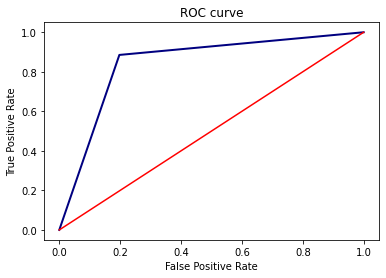

In [ ]:
plt.figure(figsize=(6, 4))
fpr, tpr, thresholds = roc_curve(y_test, predicted, pos_label=1)
plt.plot(fpr, tpr, lw=2, label='ROC curve ', color='navy')
plt.plot([0, 1], [0, 1], color = 'r')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

## Support Vector Machine

In [ ]:
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', LinearSVC())])

text_clf.fit(X_train, y_train)
predicted = text_clf.predict(X_test)
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

       False       0.90      0.89      0.90       304
        True       0.90      0.90      0.90       305

    accuracy                           0.90       609
   macro avg       0.90      0.90      0.90       609
weighted avg       0.90      0.90      0.90       609



In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, predicted).ravel()
fpr = fp / (fp + tn)
svm_rocauc = round(roc_auc_score(y_test, predicted, average='weighted'), 2)

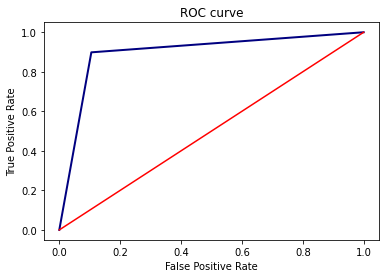

In [ ]:
plt.figure(figsize=(6, 4))
fpr, tpr, thresholds = roc_curve(y_test, predicted, pos_label=1)
plt.plot(fpr, tpr, lw=2, label='ROC curve ', color='navy')
plt.plot([0, 1], [0, 1], color = 'r')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

## Decision Tree

In [ ]:
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', tree.DecisionTreeClassifier(criterion='entropy',
                     max_depth=None, min_samples_split=2,
                     min_samples_leaf=1, max_features="sqrt", random_state=77))])

text_clf.fit(X_train, y_train)
predicted = text_clf.predict(X_test)
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

       False       0.82      0.75      0.78       304
        True       0.77      0.83      0.80       305

    accuracy                           0.79       609
   macro avg       0.79      0.79      0.79       609
weighted avg       0.79      0.79      0.79       609



In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, predicted).ravel()
fpr = fp / (fp + tn)
tpr = tp / (tp + fn)
dt_rocauc = round(roc_auc_score(y_test, predicted, average='weighted'), 2)

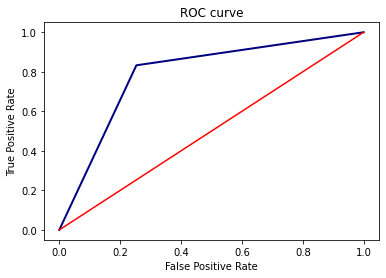

In [ ]:
plt.figure(figsize=(6, 4))
fpr, tpr, thresholds = roc_curve(y_test, predicted, pos_label=1)
plt.plot(fpr, tpr, lw=2, label='ROC curve ', color='navy')
plt.plot([0, 1], [0, 1], color = 'r')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

## Random Forest

In [ ]:
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', RandomForestClassifier(n_estimators=100,
                     criterion='entropy', max_depth=None,
                     min_samples_split=2, min_samples_leaf=1,
                     oob_score=True, n_jobs=-1,
                     max_features=10, random_state=77))])

text_clf.fit(X_train, y_train)
predicted = text_clf.predict(X_test)
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

       False       0.86      0.92      0.89       304
        True       0.92      0.85      0.88       305

    accuracy                           0.89       609
   macro avg       0.89      0.89      0.89       609
weighted avg       0.89      0.89      0.89       609



In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, predicted).ravel()
fpr = fp / (fp + tn)
tpr = tp / (tp + fn)
rf_rocauc = round(roc_auc_score(y_test, predicted, average='weighted'), 2)

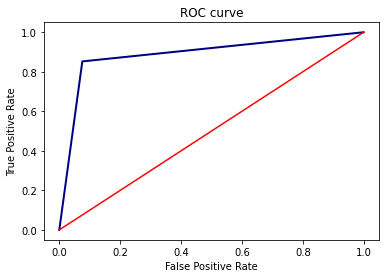

In [ ]:
plt.figure(figsize=(6, 4))
fpr, tpr, thresholds = roc_curve(y_test, predicted, pos_label=1)
plt.plot(fpr, tpr, lw=2, label='ROC curve ', color='navy')
plt.plot([0, 1], [0, 1], color = 'r')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

## Plot results

In [ ]:
rocauc = [rocchio_rocauc, boosting_rocauc, bagging_rocauc, bayes_rocauc, neighbor_rocauc, svm_rocauc, dt_rocauc, rf_rocauc]
score = [[rocchio_rocauc],[boosting_rocauc],[bagging_rocauc],[bayes_rocauc],[neighbor_rocauc],[svm_rocauc],[dt_rocauc],[rf_rocauc]]
df4 = pd.DataFrame(list(zip(score)), index =["Rocchio", "Boosting", "Bagging", "Bayes", "kNN", "SVM", "Decision Tree", "Random Forest"], columns =["Score"])

In [ ]:
index =["Rocchio", "Boosting", "Bagging", "Bayes", "kNN", "SVM", "Decision Tree", "Random Forest"]

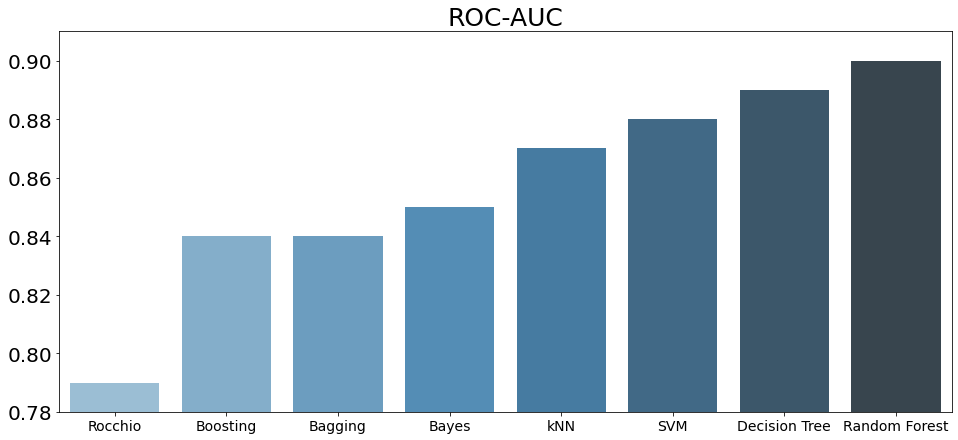

In [ ]:
plt.figure(figsize=(16, 7))
ax = sns.barplot(data = sorted(df4.Score, reverse=False), palette = "Blues_d")
ax.set_xticklabels(index, fontsize=14)
plt.yticks(fontsize=20)
plt.title("ROC-AUC", fontsize=25)
plt.ylim(min(rocauc)-0.01, max(rocauc)+0.01);